In [3]:
# Unmount Google Drive
!fusermount -u /content/drive
!umount -l /content/drive


# This mounts Google Drive to the Colab VM.
from google.colab import drive
drive.mount('/content/drive', force_remount=True)


# Define the folder where the assignment is located
FOLDERNAME = 'SAIDL/core ML'
assert FOLDERNAME is not None, "[!] Enter the foldername."

# Add the folder to the system path to access Python modules
import sys
sys.path.append('/content/drive/My Drive/{}'.format(FOLDERNAME))

# Move to the datasets directory to download CIFAR-10
%cd /content/drive/My\ Drive/$FOLDERNAME/datasets/
!bash get_datasets.sh

# Move back to the project root directory
%cd /content/drive/My\ Drive/$FOLDERNAME

umount: /content/drive: not mounted.
Mounted at /content/drive
/content/drive/My Drive/SAIDL/core ML/datasets
/content/drive/My Drive/SAIDL/core ML


In [4]:
import os

# Add the helper_functions directory to sys.path
sys.path.append(os.path.join(os.getcwd(), "helper_functions"))

# Import get_CIFAR10_data from data_utils.py
from data_utils import get_CIFAR10_data


In [5]:
%cd helper_functions

!python setup.py build_ext --inplace


/content/drive/My Drive/SAIDL/core ML/helper_functions


In [6]:
%cd ..


/content/drive/My Drive/SAIDL/core ML


In [7]:
# Load the (preprocessed) CIFAR-10 data.
data = get_CIFAR10_data()
for k, v in list(data.items()):
    print(f"{k}: {v.shape}")

X_train: (49000, 3, 32, 32)
y_train: (49000,)
X_val: (1000, 3, 32, 32)
y_val: (1000,)
X_test: (1000, 3, 32, 32)
y_test: (1000,)


In [8]:
# Setup cell.
import numpy as np
import matplotlib.pyplot as plt
#from helper_functions.classifiers.cnn import *
from helper_functions.data_utils import get_CIFAR10_data
from helper_functions.gradient_check import eval_numerical_gradient_array, eval_numerical_gradient
from helper_functions.layers import *
from helper_functions.fast_layers import *
from helper_functions.solver import Solver

%matplotlib inline
plt.rcParams["figure.figsize"] = (10.0, 8.0)  # set default size of plots
plt.rcParams["image.interpolation"] = "nearest"
plt.rcParams["image.cmap"] = "gray"

%load_ext autoreload
%autoreload 2

def rel_error(x, y):
    """ Returns relative error """
    return np.max(np.abs(x - y) / (np.maximum(1e-8, np.abs(x) + np.abs(y))))


hello worl


In [9]:
from helper_functions.apl import *

In [10]:
from helper_functions.fast_layers import conv_forward_fast, conv_backward_fast
import numpy as np
from time import time

# Set seed for reproducibility
np.random.seed(231)

# Generate random data and parameters
x = np.random.randn(100, 3, 31, 31)   # Input data
w = np.random.randn(25, 3, 3, 3)      # Filter weights
b = np.random.randn(25,)              # Bias terms
dout = np.random.randn(100, 25, 16, 16)  # Gradient wrt output
conv_param = {'stride': 2, 'pad': 1}  # Convolution parameters

# ----------------------------
# Forward Pass (FAST)
# ----------------------------
t0 = time()
out_fast, cache_fast = conv_forward_fast(x, w, b, conv_param)
t1 = time()

print('Forward pass completed in %fs' % (t1 - t0))

# ----------------------------
# Backward Pass (FAST)
# ----------------------------
t0 = time()
dx_fast, dw_fast, db_fast = conv_backward_fast(dout, cache_fast)
t1 = time()

print('Backward pass completed in %fs' % (t1 - t0))


Forward pass completed in 0.016124s
Backward pass completed in 0.041281s


In [11]:
from helper_functions.fast_layers import max_pool_forward_fast, max_pool_backward_fast
import numpy as np
from time import time

# Set seed for reproducibility
np.random.seed(231)

# Generate random input and gradient
x = np.random.randn(100, 3, 32, 32)       # Input data
dout = np.random.randn(100, 3, 16, 16)    # Gradient wrt output

# Pooling parameters
pool_param = {'pool_height': 2, 'pool_width': 2, 'stride': 2}

# ----------------------------
# Forward Pass (FAST)
# ----------------------------
t0 = time()
out_fast, cache_fast = max_pool_forward_fast(x, pool_param)
t1 = time()

print('Forward pass (fast) completed in %fs' % (t1 - t0))

# ----------------------------
# Backward Pass (FAST)
# ----------------------------
t0 = time()
dx_fast = max_pool_backward_fast(dout, cache_fast)
t1 = time()

print('Backward pass (fast) completed in %fs' % (t1 - t0))


Forward pass (fast) completed in 0.007797s
Backward pass (fast) completed in 0.024517s


Sanity check:

In [23]:
from helper_functions.cnn import ThreeLayerConvNet
model = ThreeLayerConvNet()

N = 50
X = np.random.randn(N, 3, 32, 32)
y = np.random.randint(10, size=N)

loss, grads = model.loss(X, y)
print('Initial loss (no regularization): ', loss)

model.reg = 0.5
loss, grads = model.loss(X, y)
print('Initial loss (with regularization): ', loss)

Initial loss (no regularization):  2.3025858848360223
Initial loss (with regularization):  2.508810654189889


In [24]:
num_inputs = 2
input_dim = (3, 16, 16)
reg = 0.0
num_classes = 10
np.random.seed(231)
X = np.random.randn(num_inputs, *input_dim)
y = np.random.randint(num_classes, size=num_inputs)

model = ThreeLayerConvNet(
    num_filters=3,
    filter_size=3,
    input_dim=input_dim,
    hidden_dim=7,
    dtype=np.float64
)
loss, grads = model.loss(X, y)
# Errors should be small, but correct implementations may have
# relative errors up to the order of e-2
for param_name in sorted(grads):
    f = lambda _: model.loss(X, y)[0]
    param_grad_num = eval_numerical_gradient(f, model.params[param_name], verbose=False, h=1e-6)
    e = rel_error(param_grad_num, grads[param_name])
    print('%s max relative error: %e' % (param_name, rel_error(param_grad_num, grads[param_name])))

W1 max relative error: 1.380104e-04
W2 max relative error: 1.822723e-02
W3 max relative error: 3.064049e-04
b1 max relative error: 3.477652e-05
b2 max relative error: 2.516375e-03
b3 max relative error: 7.945660e-10


All the loss functions are present in layers.py

In [25]:
from torch.utils.data import DataLoader, TensorDataset
import torch

def get_custom_loaders(data_dict, batch_size):
    """Create DataLoaders from small_data."""
    X_train, y_train = data_dict["X_train"], data_dict["y_train"]
    X_val, y_val = data_dict["X_val"], data_dict["y_val"]

    # ✅ Correct: Permute dimensions before converting to tensor
    X_train_tensor = torch.tensor(X_train, dtype=torch.float32)
    y_train_tensor = torch.tensor(y_train, dtype=torch.long)

    X_val_tensor = torch.tensor(X_val, dtype=torch.float32)
    y_val_tensor = torch.tensor(y_val, dtype=torch.long)

    # Create TensorDatasets
    train_dataset = TensorDataset(X_train_tensor, y_train_tensor)
    val_dataset = TensorDataset(X_val_tensor, y_val_tensor)

    # Create DataLoaders
    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
    test_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)

    return train_loader, test_loader


Overfitting small data for optimization:

In [148]:
import numpy as np
import matplotlib.pyplot as plt
from solver import Solver
from cnn import ThreeLayerConvNet
from helper_functions.apl import *  # ✅ Correct import

# ========================
# ✅ Data Preparation
# ========================
np.random.seed(231)

num_train = 100
small_data = {
    "X_train": data["X_train"][:num_train],
    "y_train": data["y_train"][:num_train],
    "X_val": data["X_val"],
    "y_val": data["y_val"],
}

# ✅ Define batch size and create loaders once for all models
batch_size = 50  # Consistent batch size
train_loader, test_loader = get_custom_loaders(small_data, batch_size)

# ========================
# ✅ Dictionary to store trained models, loss histories, and accuracy histories
# ========================
trained_models = {}
loss_histories = {}
acc_histories = {}
test_loaders = {}  # ✅ Store test loaders for APL

# ✅ Corrected loss types
loss_types = ["ce", "nce", "apl"]

# ========================
# ✅ Train with Different Loss Types
# ========================
for loss_type in loss_types:
    if loss_type == "apl":
        print(f"Training with APL using PyTorch implementation from helper_functions.apl...")

        # ✅ Run APL with predefined loaders and batch size
        (
            apl_model,
            apl_test_loader,
            active_loss_history,
            passive_loss_history,
            train_acc_history,
            val_acc_history,
        ) = run_apl(
            alpha=0.8,
            lr=5e-4,
            num_epochs=15,
            batch_size=batch_size,
            train_loader=train_loader,
            test_loader=test_loader,
        )

        # ✅ Check if APL model was trained successfully
        if apl_model is None:
            raise ValueError("APL model training failed! Check run_apl() function.")

        print("✅ APL model successfully trained!")

        # ✅ Store trained APL model and test loader
        trained_models["apl"] = apl_model
        test_loaders["apl"] = apl_test_loader

        # ✅ Store APL loss histories
        loss_histories["apl"] = {
            "active_loss": active_loss_history,
            "passive_loss": passive_loss_history,
        }

        # ✅ Store APL accuracy histories
        acc_histories["apl"] = {
            "train": train_acc_history,
            "val": val_acc_history,
        }

    else:
        # ✅ For CE and NCE, use NumPy-based ThreeLayerConvNet
        print(f"Training with {loss_type.upper()} using ThreeLayerConvNet...")

        model = ThreeLayerConvNet(weight_scale=1e-2)

        # ✅ Default Solver for CE/NCE with consistent batch size
        solver = Solver(
            model,
            small_data,  # ✅ Same small_data for CE/NCE
            num_epochs=15,
            batch_size=batch_size,  # ✅ Consistent batch size
            update_rule="adam",
            optim_config={"learning_rate": 5e-4},
            verbose=True,
            print_every=1,
        )

        # 🔥 Train with specified loss type
        solver._train_with_loss_type(loss_type)

        # ✅ Store trained model parameters
        trained_models[loss_type] = {k: v.copy() for k, v in solver.model.params.items()}

        # ✅ Store loss history for this loss type
        loss_histories[loss_type] = (
            solver.ce_loss_history if loss_type == "ce" else solver.nce_loss_history
        )

        # ✅ Store accuracy histories for this loss type
        acc_histories[loss_type] = {
            "train": (
                solver.ce_train_acc_history
                if loss_type == "ce"
                else solver.nce_train_acc_history
            ),
            "val": (
                solver.ce_val_acc_history
                if loss_type == "ce"
                else solver.nce_val_acc_history
            ),
        }


Training with CE using ThreeLayerConvNet...
(Iteration 1 / 30) CE loss: 2.4933
(Epoch 0 / 15) CE train acc: 15.00; CE val acc: 9.70
(Iteration 2 / 30) CE loss: 2.2959
(Epoch 1 / 15) CE train acc: 35.00; CE val acc: 16.40
(Iteration 3 / 30) CE loss: 2.0213
(Iteration 4 / 30) CE loss: 2.0518
(Epoch 2 / 15) CE train acc: 41.00; CE val acc: 11.20
(Iteration 5 / 30) CE loss: 1.8455
(Iteration 6 / 30) CE loss: 1.4991
(Epoch 3 / 15) CE train acc: 64.00; CE val acc: 15.60
(Iteration 7 / 30) CE loss: 1.4747
(Iteration 8 / 30) CE loss: 1.2746
(Epoch 4 / 15) CE train acc: 62.00; CE val acc: 16.80
(Iteration 9 / 30) CE loss: 1.0628
(Iteration 10 / 30) CE loss: 0.9506
(Epoch 5 / 15) CE train acc: 81.00; CE val acc: 14.70
(Iteration 11 / 30) CE loss: 0.8030
(Iteration 12 / 30) CE loss: 0.6902
(Epoch 6 / 15) CE train acc: 82.00; CE val acc: 17.30
(Iteration 13 / 30) CE loss: 0.7068
(Iteration 14 / 30) CE loss: 0.7033
(Epoch 7 / 15) CE train acc: 84.00; CE val acc: 19.10
(Iteration 15 / 30) CE loss: 0

In [ ]:
print(f"Available models: {list(trained_models.keys())}")


Available models: ['ce', 'nce', 'apl']


In [ ]:
import torch
import numpy as np
from cnn import ThreeLayerConvNet

# ========================
# ✅ Define device
# ========================
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# ========================
# ✅ Initialize trained models & test loaders only ONCE
# ========================
if "trained_models" not in globals():
    trained_models = {}
    test_loaders = {}

# ✅ Check available models before checking accuracies
print(f"Available models before checking accuracy: {list(trained_models.keys())}")

# ========================
# ✅ Define reset_model() correctly
# ========================
def reset_model():
    """Reinitialize and return a new ThreeLayerConvNet."""
    return ThreeLayerConvNet(weight_scale=1e-2)

# ========================
# ✅ Loop to check accuracies
# ========================
for loss_type in trained_models.keys():  # ✅ Iterate only over available models
    if loss_type == "apl":
        print(f"Checking accuracy for APL model...")
        apl_model = trained_models["apl"]
        apl_model.to(device)
        apl_model.eval()

        # ✅ APL Accuracy on Training Data
        X_train_tensor = torch.tensor(
            small_data["X_train"], dtype=torch.float32
        ).to(device)
        y_train_tensor = torch.tensor(small_data["y_train"], dtype=torch.long).to(device)

        with torch.no_grad():
            outputs_train = apl_model(X_train_tensor)
            _, predicted_train = torch.max(outputs_train, 1)
            train_correct = (predicted_train == y_train_tensor).sum().item()
            train_acc = 100 * train_correct / y_train_tensor.size(0)

        print(f"APL Train Accuracy: {train_acc:.2f}%")

        # ✅ APL Accuracy on Validation Data
        X_val_tensor = torch.tensor(
            small_data["X_val"], dtype=torch.float32
        ).to(device)
        y_val_tensor = torch.tensor(small_data["y_val"], dtype=torch.long).to(device)

        with torch.no_grad():
            outputs_val = apl_model(X_val_tensor)
            _, predicted_val = torch.max(outputs_val, 1)
            val_correct = (predicted_val == y_val_tensor).sum().item()
            val_acc = 100 * val_correct / y_val_tensor.size(0)

        print(f"APL Validation Accuracy: {val_acc:.2f}%\n")

    else:
        print(f"Checking accuracy for {loss_type.upper()} model...")

        # ✅ Correctly reset and load the model for CE/NCE
        model = reset_model()
        if loss_type in trained_models and "W1" in trained_models[loss_type]:
            model.params = {k: v.copy() for k, v in trained_models[loss_type].items()}  # ✅ Correctly load model params
        else:
            print(f"⚠️ Warning: No trained model found for {loss_type.upper()}. Skipping...")
            continue

        # ✅ CE/NCE Accuracy on Training Data
        X_train_np = small_data["X_train"]  # ✅ Remove transpose, already (N, C, H, W)
        scores_train = model.loss(X_train_np)
        predicted_train = np.argmax(scores_train, axis=1)
        train_correct = np.sum(predicted_train == small_data["y_train"])
        train_acc = 100 * train_correct / small_data["y_train"].shape[0]

        print(f"Training accuracy with {loss_type.upper()} loss: {train_acc:.2f}%")

        # ✅ CE/NCE Accuracy on Validation Data
        X_val_np = small_data["X_val"]  # ✅ Remove transpose, already (N, C, H, W)
        scores_val = model.loss(X_val_np)
        predicted_val = np.argmax(scores_val, axis=1)
        val_correct = np.sum(predicted_val == small_data["y_val"])
        val_acc = 100 * val_correct / small_data["y_val"].shape[0]

        print(f"Validation accuracy with {loss_type.upper()} loss: {val_acc:.2f}%\n")

# ✅ Final check after all accuracies
print(f"✅ Available models after checking: {list(trained_models.keys())}")


Available models before checking accuracy: ['ce', 'nce', 'apl']
Checking accuracy for CE model...
Training accuracy with CE loss: 98.00%
Validation accuracy with CE loss: 25.30%

Checking accuracy for NCE model...
Training accuracy with NCE loss: 90.00%
Validation accuracy with NCE loss: 25.20%

Checking accuracy for APL model...
APL Train Accuracy: 94.00%
APL Validation Accuracy: 19.10%

✅ Available models after checking: ['ce', 'nce', 'apl']


above shows clear overfitting

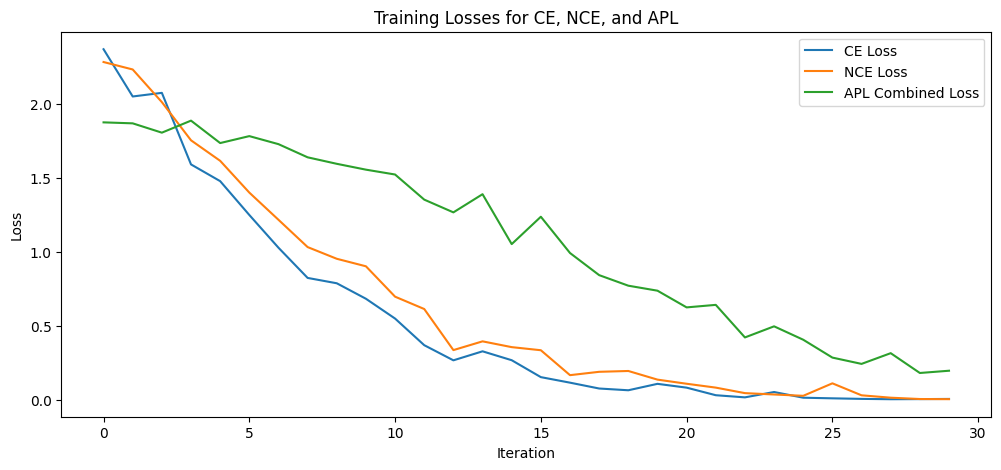

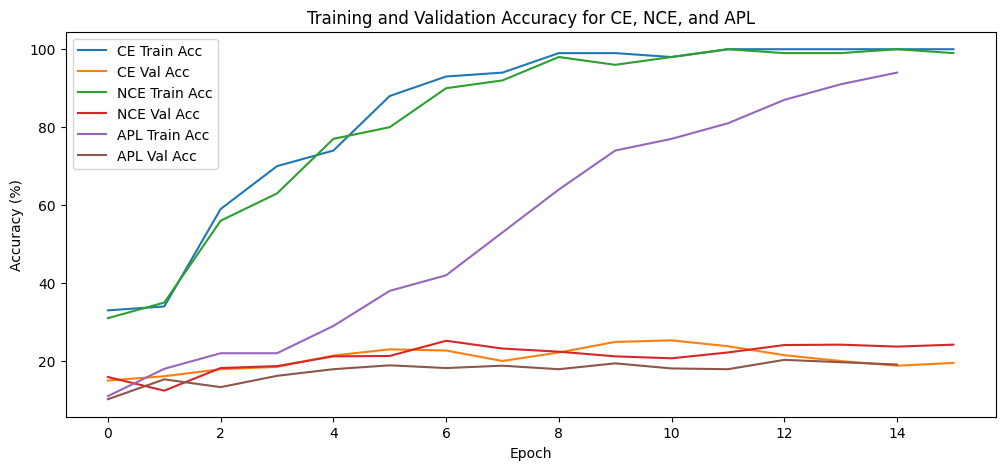

In [ ]:
plt.figure(figsize=(12, 5))

# ✅ Plot CE and NCE Losses
for loss_type in ["ce", "nce"]:
    plt.plot(loss_histories[loss_type], label=f"{loss_type.upper()} Loss")

# ✅ Plot APL Active/Passive Losses
# ✅ Plot Combined APL Loss
if "apl" in loss_histories:
    combined_apl_loss = [
        alpha * active + (1 - alpha) * passive
        for active, passive in zip(
            loss_histories["apl"]["active_loss"], loss_histories["apl"]["passive_loss"]
        )
    ]
    plt.plot(combined_apl_loss, label="APL Combined Loss")


plt.title("Training Losses for CE, NCE, and APL")
plt.xlabel("Iteration")
plt.ylabel("Loss")
plt.legend()
plt.show()

# ✅ Plot Training and Validation Accuracy
plt.figure(figsize=(12, 5))
for loss_type in acc_histories:
    plt.plot(acc_histories[loss_type]["train"], label=f"{loss_type.upper()} Train Acc")
    plt.plot(acc_histories[loss_type]["val"], label=f"{loss_type.upper()} Val Acc")

plt.title("Training and Validation Accuracy for CE, NCE, and APL")
plt.xlabel("Epoch")
plt.ylabel("Accuracy (%)")
plt.legend()
plt.show()

Run if you want to delete previously stored data

In [ ]:
import os

# List of loss types you want to delete checkpoints for
loss_types_to_delete = ["ce", "nce","apl"]

# Directory containing the checkpoints
checkpoint_dir = "checkpoints"

# Delete the checkpoint files for the specified loss types
for loss_type in loss_types_to_delete:
    checkpoint_path = os.path.join(checkpoint_dir, f"model_checkpoint_{loss_type}.pkl")
    if os.path.exists(checkpoint_path):
        os.remove(checkpoint_path)
        print(f"Checkpoint for {loss_type.upper()} deleted successfully! ❌")
    else:
        print(f"No checkpoint found for {loss_type.upper()} to delete.")


No checkpoint found for CE to delete.
No checkpoint found for NCE to delete.
No checkpoint found for APL to delete.


In [ ]:
import pickle
import os
import numpy as np
import matplotlib.pyplot as plt
from solver import Solver
from cnn import ThreeLayerConvNet
from helper_functions.apl import run_apl  # ✅ Corrected Import for APL

# ========================
# ✅ Define Paths and Params
# ========================
checkpoint_dir = "checkpoints"
os.makedirs(checkpoint_dir, exist_ok=True)

loss_types = ["ce", "nce", "apl"]
weight_scale = 0.001
hidden_dim = 500
reg = 0.001
alpha = 0.7  # ✅ APL Alpha (Keep consistent)

# Initialize Variables to store training stats
trained_models = {}
loss_histories = {}
acc_histories = {}

# ========================
# ✅ Training Loop for All Loss Types
# ========================
for loss_type in loss_types:
    checkpoint_path = os.path.join(checkpoint_dir, f"model_checkpoint_{loss_type}.pkl")

    # ========================
    # 🔄 Check if Checkpoint Exists
    # ========================
    if os.path.exists(checkpoint_path):
        print(f"Loading model for {loss_type.upper()} from checkpoint...")
        with open(checkpoint_path, "rb") as f:
            checkpoint = pickle.load(f)

        if loss_type == "apl":
            # ✅ Restore PyTorch APL model and solver stats
            apl_model = checkpoint["model"]
            train_acc_history = checkpoint["train_acc_history"]
            val_acc_history = checkpoint["val_acc_history"]
            combined_apl_loss_history = checkpoint["apl_loss_history"]
            print(f"{loss_type.upper()} checkpoint loaded successfully! ✅")

        else:
            # ✅ Restore CE/NCE models using ThreeLayerConvNet
            model = ThreeLayerConvNet(weight_scale=weight_scale, hidden_dim=hidden_dim, reg=reg)
            model.params = checkpoint["model"]

            # Reinitialize solver with loaded model
            solver = Solver(
                model,
                data,
                num_epochs=0,  # Skip retraining if not needed
                batch_size=50,
                update_rule="adam",
                optim_config={"learning_rate": 1e-3},
                verbose=True,
                print_every=20,
            )
            print(f"{loss_type.upper()} checkpoint loaded successfully! ✅")

    else:
        print(f"No checkpoint found for {loss_type.upper()}. Training from scratch...")

        # ========================
        # ⚡️ Initialize and Train Model
        # ========================
        if loss_type == "apl":
            # ✅ Use PyTorch APL Implementation
            (
                apl_model,
                test_loader,
                active_loss_history,
                passive_loss_history,
                train_acc_history,
                val_acc_history,
            ) = run_apl(
                alpha=alpha,
                lr=1e-3,
                num_epochs=1,  # ⚠️ Set to the same num_epochs as CE/NCE
                batch_size=50,
                print_every=20,
            )

            # ✅ Combine APL Losses (Active + Passive)
            combined_apl_loss_history = [
                alpha * active + (1 - alpha) * passive
                for active, passive in zip(active_loss_history, passive_loss_history)
            ]

            # ========================
            # 💾 Save Checkpoint After Training
            # ========================
            with open(checkpoint_path, "wb") as f:
                pickle.dump(
                    {
                        "model": apl_model.state_dict(),
                        "apl_loss_history": combined_apl_loss_history,
                        "train_acc_history": train_acc_history,
                        "val_acc_history": val_acc_history,
                    },
                    f,
                )
            print(f"Checkpoint for {loss_type.upper()} saved after training! 🎉")

        else:
            # ✅ CE and NCE (No Change)
            model = ThreeLayerConvNet(weight_scale=weight_scale, hidden_dim=hidden_dim, reg=reg)
            solver = Solver(
                model,
                data,
                num_epochs=1,  # ⚠️ Keep the same number of epochs as APL
                batch_size=50,
                update_rule="adam",
                optim_config={"learning_rate": 1e-3},
                verbose=True,
                print_every=20,
            )

            # 🔥 Train Model with Specific Loss Type
            solver._train_with_loss_type(loss_type)

            # 💾 Save Checkpoint After Training
            with open(checkpoint_path, "wb") as f:
                pickle.dump({"model": model.params, "solver": solver}, f)
            print(f"Checkpoint for {loss_type.upper()} saved after training! 🎉")

    # ========================
    # ✅ Store Training Results
    # ========================
    if loss_type == "apl":
        # ✅ Store PyTorch APL Results
        trained_models["apl"] = apl_model
        loss_histories["apl"] = combined_apl_loss_history
        acc_histories["apl"] = {"train": train_acc_history, "val": val_acc_history}
    else:
        # ✅ Store CE/NCE Results as Before
        trained_models[loss_type] = {k: v.copy() for k, v in solver.model.params.items()}
        loss_histories[loss_type] = (
            solver.ce_loss_history
            if loss_type == "ce"
            else solver.nce_loss_history
        )
        acc_histories[loss_type] = {
            "train": solver.ce_train_acc_history
            if loss_type == "ce"
            else solver.nce_train_acc_history,
            "val": solver.ce_val_acc_history
            if loss_type == "ce"
            else solver.nce_val_acc_history,
        }


No checkpoint found for CE. Training from scratch...
(Iteration 1 / 980) CE loss: 2.3050
(Epoch 0 / 1) CE train acc: 7.40; CE val acc: 8.70
(Iteration 21 / 980) CE loss: 2.3575
(Iteration 41 / 980) CE loss: 1.8891
(Iteration 61 / 980) CE loss: 2.3248
(Iteration 81 / 980) CE loss: 1.8947
(Iteration 101 / 980) CE loss: 1.7034
(Iteration 121 / 980) CE loss: 1.6720
(Iteration 141 / 980) CE loss: 1.7307
(Iteration 161 / 980) CE loss: 1.9567
(Iteration 181 / 980) CE loss: 1.8119
(Iteration 201 / 980) CE loss: 1.5937
(Iteration 221 / 980) CE loss: 1.9851
(Iteration 241 / 980) CE loss: 1.5981
(Iteration 261 / 980) CE loss: 1.5911
(Iteration 281 / 980) CE loss: 1.7267
(Iteration 301 / 980) CE loss: 1.8447
(Iteration 321 / 980) CE loss: 1.5425
(Iteration 341 / 980) CE loss: 1.8081
(Iteration 361 / 980) CE loss: 1.7167
(Iteration 381 / 980) CE loss: 1.5940
(Iteration 401 / 980) CE loss: 1.8676
(Iteration 421 / 980) CE loss: 1.4292
(Iteration 441 / 980) CE loss: 1.6872
(Iteration 461 / 980) CE los

In [ ]:
import pickle

# Save model and solver after training
with open("model_checkpoint.pkl", "wb") as f:
    pickle.dump({"model": model.params, "solver": solver}, f)


In [ ]:
from apl import APLCNN


In [ ]:
import torch
import numpy as np
from cnn import ThreeLayerConvNet

# ========================
# ✅ Define device
# ========================
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# ========================
# ✅ Initialize trained models & test loaders only ONCE
# ========================
if "trained_models" not in globals():
    trained_models = {}
    test_loaders = {}

# ✅ Check available models before checking accuracies
print(f"Available models before checking accuracy: {list(trained_models.keys())}")

# ========================
# ✅ Define reset_model() correctly
# ========================
def reset_model():
    """Reinitialize and return a new ThreeLayerConvNet."""
    return ThreeLayerConvNet(weight_scale=1e-2)  # ✅ Use same weight_scale as training

# ========================
# ✅ Loop to check accuracies
# ========================
for loss_type in trained_models.keys():  # ✅ Iterate only over available models
    if loss_type == "apl":
        print(f"Checking accuracy for APL model...")

        # ✅ Import APLNet correctly
        from apl import APLCNN

        # ✅ Reinitialize APLNet and load the saved state_dict
        apl_model = APLCNN(input_dim=(3, 32, 32), num_classes=10).to(device)
        apl_model.load_state_dict(trained_models["apl"])  # ✅ Load state_dict correctly
        apl_model.eval()

        # ✅ APL Accuracy on Training Data
        X_train_tensor = torch.tensor(
            small_data["X_train"], dtype=torch.float32
        ).to(device)
        y_train_tensor = torch.tensor(small_data["y_train"], dtype=torch.long).to(device)

        with torch.no_grad():
            outputs_train = apl_model(X_train_tensor)
            _, predicted_train = torch.max(outputs_train, 1)
            train_correct = (predicted_train == y_train_tensor).sum().item()
            train_acc = 100 * train_correct / y_train_tensor.size(0)

        print(f"APL Train Accuracy: {train_acc:.2f}%")

        # ✅ APL Accuracy on Validation Data
        X_val_tensor = torch.tensor(
            small_data["X_val"], dtype=torch.float32
        ).to(device)
        y_val_tensor = torch.tensor(small_data["y_val"], dtype=torch.long).to(device)

        with torch.no_grad():
            outputs_val = apl_model(X_val_tensor)
            _, predicted_val = torch.max(outputs_val, 1)
            val_correct = (predicted_val == y_val_tensor).sum().item()
            val_acc = 100 * val_correct / y_val_tensor.size(0)

        print(f"APL Validation Accuracy: {val_acc:.2f}%\n")

    else:
        print(f"Checking accuracy for {loss_type.upper()} model...")

        # ✅ Correctly reset and load the model for CE/NCE
        model = reset_model()
        if loss_type in trained_models and "W1" in trained_models[loss_type]:
            model.params = {k: v.copy() for k, v in trained_models[loss_type].items()}  # ✅ Correctly load model params
        else:
            print(f"⚠️ Warning: No trained model found for {loss_type.upper()}. Skipping...")
            continue

        # ✅ CE/NCE Accuracy on Training Data
        X_train_np = small_data["X_train"]  # ✅ No need for transpose, already (N, C, H, W)
        scores_train = model.loss(X_train_np)
        predicted_train = np.argmax(scores_train, axis=1)
        train_correct = np.sum(predicted_train == small_data["y_train"])
        train_acc = 100 * train_correct / small_data["y_train"].shape[0]

        print(f"Training accuracy with {loss_type.upper()} loss: {train_acc:.2f}%")

        # ✅ CE/NCE Accuracy on Validation Data
        X_val_np = small_data["X_val"]  # ✅ No need for transpose, already (N, C, H, W)
        scores_val = model.loss(X_val_np)
        predicted_val = np.argmax(scores_val, axis=1)
        val_correct = np.sum(predicted_val == small_data["y_val"])
        val_acc = 100 * val_correct / small_data["y_val"].shape[0]

        print(f"Validation accuracy with {loss_type.upper()} loss: {val_acc:.2f}%\n")

# ✅ Final check after all accuracies
print(f"✅ Available models after checking: {list(trained_models.keys())}")


Available models before checking accuracy: ['ce', 'nce', 'apl']
Checking accuracy for CE model...
Training accuracy with CE loss: 46.00%
Validation accuracy with CE loss: 48.40%

Checking accuracy for NCE model...
Training accuracy with NCE loss: 49.00%
Validation accuracy with NCE loss: 49.30%

Checking accuracy for APL model...
APL Train Accuracy: 39.00%
APL Validation Accuracy: 43.40%

✅ Available models after checking: ['ce', 'nce', 'apl']


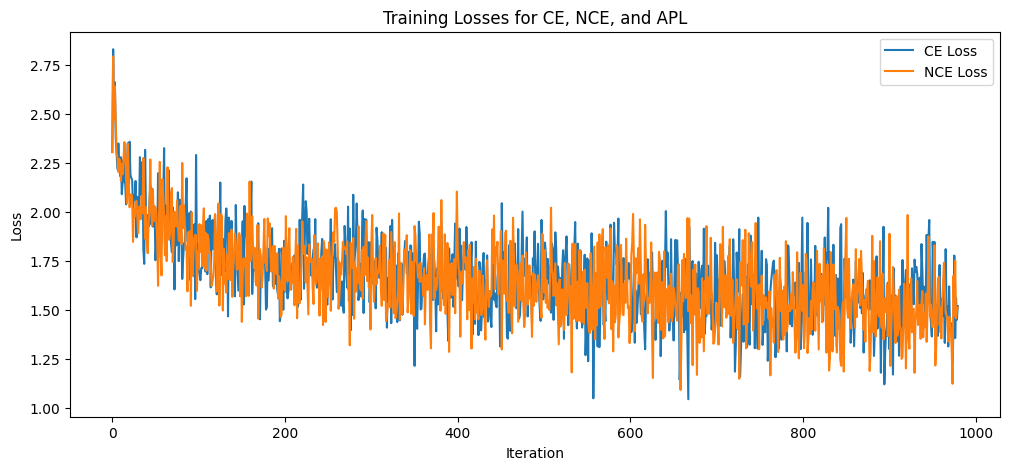

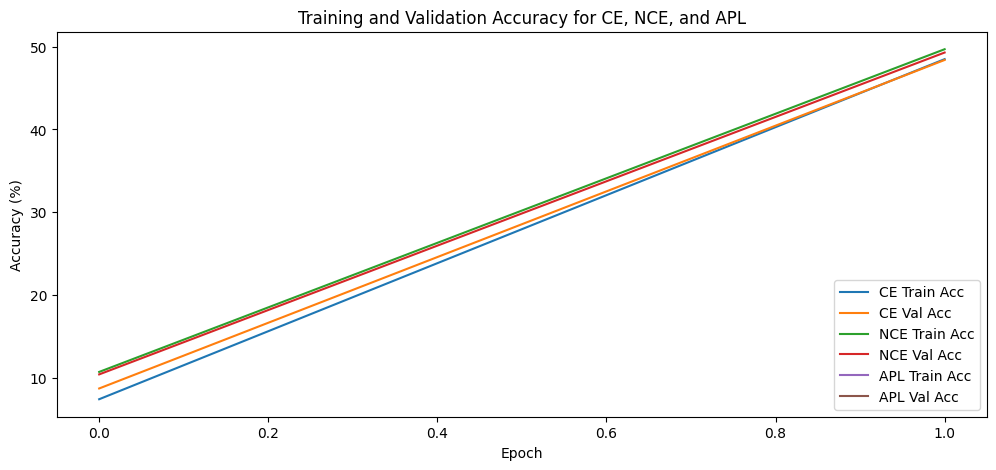

In [ ]:
import matplotlib.pyplot as plt

plt.figure(figsize=(12, 5))

# ✅ Plot CE and NCE Losses
for loss_type in ["ce", "nce"]:
    if loss_type in loss_histories:
        plt.plot(loss_histories[loss_type], label=f"{loss_type.upper()} Loss")

# ✅ Plot APL Active/Passive Losses
if "apl" in loss_histories and isinstance(loss_histories["apl"], dict):
    combined_apl_loss = [
        alpha * active + (1 - alpha) * passive
        for active, passive in zip(
            loss_histories["apl"]["active_loss"], loss_histories["apl"]["passive_loss"]
        )
    ]
    plt.plot(combined_apl_loss, label="APL Combined Loss")

plt.title("Training Losses for CE, NCE, and APL")
plt.xlabel("Iteration")
plt.ylabel("Loss")
plt.legend()
plt.show()

# ✅ Plot Training and Validation Accuracy
plt.figure(figsize=(12, 5))
for loss_type in acc_histories:
    if "train" in acc_histories[loss_type] and "val" in acc_histories[loss_type]:
        plt.plot(acc_histories[loss_type]["train"], label=f"{loss_type.upper()} Train Acc")
        plt.plot(acc_histories[loss_type]["val"], label=f"{loss_type.upper()} Val Acc")

plt.title("Training and Validation Accuracy for CE, NCE, and APL")
plt.xlabel("Epoch")
plt.ylabel("Accuracy (%)")
plt.legend()
plt.show()


NOW, Let's introduce some noise

In [ ]:
import os

# List of loss types you want to delete checkpoints for
loss_types_to_delete = ["ce", "nce","apl"]

# Directory containing the checkpoints
checkpoint_dir = "checkpoints"

# Delete the checkpoint files for the specified loss types
for loss_type in loss_types_to_delete:
    checkpoint_path = os.path.join(checkpoint_dir, f"model_checkpoint_{loss_type}.pkl")
    if os.path.exists(checkpoint_path):
        os.remove(checkpoint_path)
        print(f"Checkpoint for {loss_type.upper()} deleted successfully! ❌")
    else:
        print(f"No checkpoint found for {loss_type.upper()} to delete.")


Checkpoint for CE deleted successfully! ❌
Checkpoint for NCE deleted successfully! ❌
Checkpoint for APL deleted successfully! ❌


Before adding noise:

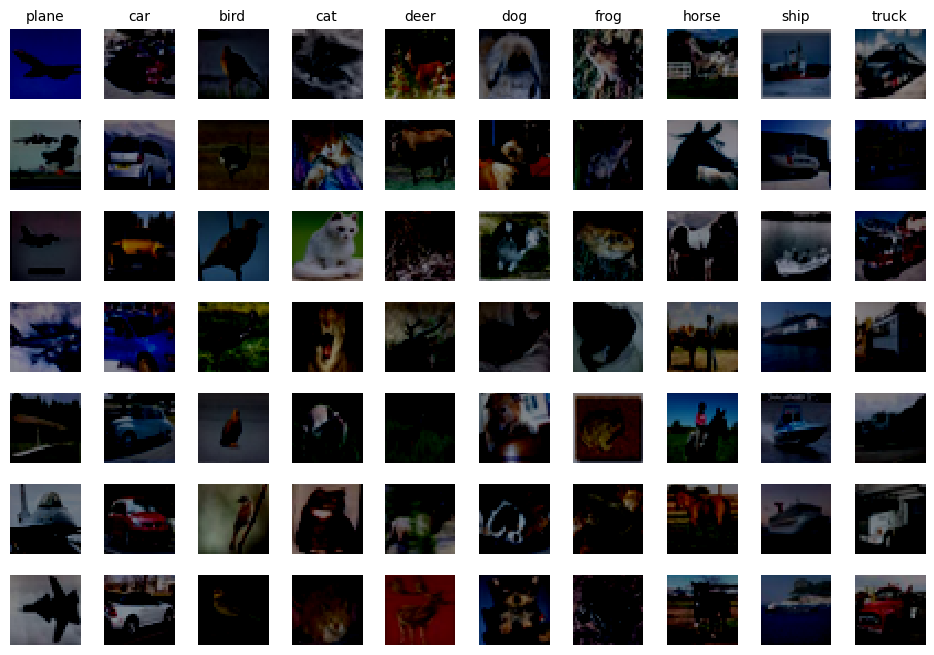

In [12]:
# Define CIFAR-10 class labels
class_labels = ['plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']
num_classes = len(class_labels)
samples_per_class = 7

# Clip and normalize for visualization
def clip_and_normalize(X):
    """Clip values to [0, 255] and convert to uint8 for visualization."""
    X = np.clip(X, 0, 255)
    X = X.astype('uint8')
    return X

# Visualize noisy training samples from each class
plt.figure(figsize=(12, 8))  # Smaller figure size
for y, cls in enumerate(class_labels):
    # Get indices of samples belonging to class y
    idxs = np.flatnonzero(data['y_train'] == y)
    idxs = np.random.choice(idxs, samples_per_class, replace=False)

    for i, idx in enumerate(idxs):
        plt_idx = i * num_classes + y + 1
        plt.subplot(samples_per_class, num_classes, plt_idx)

        # Transpose and normalize image for visualization
        img = data['X_train'][idx].transpose(1, 2, 0)
        img = clip_and_normalize(img)

        plt.imshow(img)
        plt.axis('off')
        if i == 0:
            plt.title(cls, fontsize=10)

# Add padding between subplots
plt.subplots_adjust(wspace=0.1, hspace=0.3)
plt.show()


In [13]:
import numpy as np

def add_symmetric_noise(y, num_classes=10, noise_rate=0.2, seed=None):
    """
    Add symmetric noise to labels by randomly flipping a percentage of labels.

    Args:
        y (np.array): Original labels (shape: N,)
        num_classes (int): Number of classes in the dataset (default: 10 for CIFAR-10)
        noise_rate (float): Noise rate in range [0, 1]
        seed (int): Random seed for reproducibility

    Returns:
        np.array: Noisy labels
    """
    if seed is not None:
        np.random.seed(seed)

    # Copy the original labels to avoid modifying them
    y_noisy = np.copy(y)
    num_samples = len(y)

    # Calculate the number of labels to corrupt
    num_noisy = int(noise_rate * num_samples)

    # Choose random indices to corrupt
    noisy_indices = np.random.choice(num_samples, num_noisy, replace=False)

    for i in noisy_indices:
        # Randomly choose a different class for the corrupted label
        noisy_label = np.random.choice(num_classes)
        while noisy_label == y[i]:
            noisy_label = np.random.choice(num_classes)

        y_noisy[i] = noisy_label

    return y_noisy


In [14]:
# Add symmetric noise to training labels
noise_rate = 0.6
y_train_noisy = add_symmetric_noise(data['y_train'], noise_rate=noise_rate)

# Replace original labels with noisy labels for training
data['y_train'] = y_train_noisy


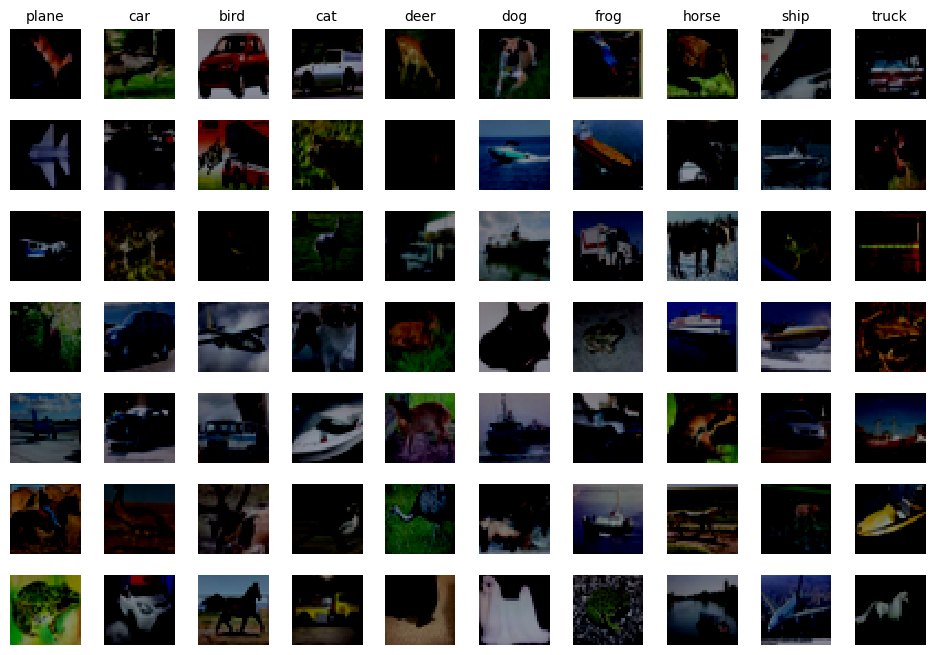

In [15]:
# Define CIFAR-10 class labels
class_labels = ['plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']
num_classes = len(class_labels)
samples_per_class = 7

# Clip and normalize for visualization
def clip_and_normalize(X):
    """Clip values to [0, 255] and convert to uint8 for visualization."""
    X = np.clip(X, 0, 255)
    X = X.astype('uint8')
    return X

# Visualize noisy training samples from each class
plt.figure(figsize=(12, 8))  # Smaller figure size
for y, cls in enumerate(class_labels):
    # Get indices of samples belonging to class y
    idxs = np.flatnonzero(data['y_train'] == y)
    idxs = np.random.choice(idxs, samples_per_class, replace=False)

    for i, idx in enumerate(idxs):
        plt_idx = i * num_classes + y + 1
        plt.subplot(samples_per_class, num_classes, plt_idx)

        # Transpose and normalize image for visualization
        img = data['X_train'][idx].transpose(1, 2, 0)
        img = clip_and_normalize(img)

        plt.imshow(img)
        plt.axis('off')
        if i == 0:
            plt.title(cls, fontsize=10)

# Add padding between subplots
plt.subplots_adjust(wspace=0.1, hspace=0.3)
plt.show()


In [16]:
from helper_functions.fast_layers import conv_forward_fast, conv_backward_fast
import numpy as np
from time import time

# Set seed for reproducibility
np.random.seed(231)

# Generate random data and parameters
x = np.random.randn(100, 3, 31, 31)   # Input data
w = np.random.randn(25, 3, 3, 3)      # Filter weights
b = np.random.randn(25,)              # Bias terms
dout = np.random.randn(100, 25, 16, 16)  # Gradient wrt output
conv_param = {'stride': 2, 'pad': 1}  # Convolution parameters

# ----------------------------
# Forward Pass (FAST)
# ----------------------------
t0 = time()
out_fast, cache_fast = conv_forward_fast(x, w, b, conv_param)
t1 = time()

print('Forward pass completed in %fs' % (t1 - t0))

# ----------------------------
# Backward Pass (FAST)
# ----------------------------
t0 = time()
dx_fast, dw_fast, db_fast = conv_backward_fast(dout, cache_fast)
t1 = time()

print('Backward pass completed in %fs' % (t1 - t0))


Forward pass completed in 0.010335s
Backward pass completed in 0.017424s


In [17]:
from helper_functions.fast_layers import max_pool_forward_fast, max_pool_backward_fast
import numpy as np
from time import time

# Set seed for reproducibility
np.random.seed(231)

# Generate random input and gradient
x = np.random.randn(100, 3, 32, 32)       # Input data
dout = np.random.randn(100, 3, 16, 16)    # Gradient wrt output

# Pooling parameters
pool_param = {'pool_height': 2, 'pool_width': 2, 'stride': 2}

# ----------------------------
# Forward Pass (FAST)
# ----------------------------
t0 = time()
out_fast, cache_fast = max_pool_forward_fast(x, pool_param)
t1 = time()

print('Forward pass (fast) completed in %fs' % (t1 - t0))

# ----------------------------
# Backward Pass (FAST)
# ----------------------------
t0 = time()
dx_fast = max_pool_backward_fast(dout, cache_fast)
t1 = time()

print('Backward pass (fast) completed in %fs' % (t1 - t0))


Forward pass (fast) completed in 0.004454s
Backward pass (fast) completed in 0.012685s


In [18]:
from helper_functions.cnn import ThreeLayerConvNet
model = ThreeLayerConvNet()

N = 50
X = np.random.randn(N, 3, 32, 32)
y = np.random.randint(10, size=N)

loss, grads = model.loss(X, y)
print('Initial loss (no regularization): ', loss)

model.reg = 0.5
loss, grads = model.loss(X, y)
print('Initial loss (with regularization): ', loss)

Initial loss (no regularization):  2.3025858848360223
Initial loss (with regularization):  2.508810654189889


In [19]:
num_inputs = 2
input_dim = (3, 16, 16)
reg = 0.0
num_classes = 10
np.random.seed(231)
X = np.random.randn(num_inputs, *input_dim)
y = np.random.randint(num_classes, size=num_inputs)

model = ThreeLayerConvNet(
    num_filters=3,
    filter_size=3,
    input_dim=input_dim,
    hidden_dim=7,
    dtype=np.float64
)
loss, grads = model.loss(X, y)
# Errors should be small, but correct implementations may have
# relative errors up to the order of e-2
for param_name in sorted(grads):
    f = lambda _: model.loss(X, y)[0]
    param_grad_num = eval_numerical_gradient(f, model.params[param_name], verbose=False, h=1e-6)
    e = rel_error(param_grad_num, grads[param_name])
    print('%s max relative error: %e' % (param_name, rel_error(param_grad_num, grads[param_name])))

W1 max relative error: 1.380104e-04
W2 max relative error: 1.822723e-02
W3 max relative error: 3.064049e-04
b1 max relative error: 3.477652e-05
b2 max relative error: 2.516375e-03
b3 max relative error: 7.945660e-10


In [36]:
from torch.utils.data import DataLoader, TensorDataset
import torch

def get_custom_loaders(data_dict, batch_size):
    """Create DataLoaders from small_data with train/validation split."""
    X_train, y_train = data_dict["X_train"], data_dict["y_train"]
    X_val, y_val = data_dict["X_val"], data_dict["y_val"]

    # ✅ Correct: Convert to tensors
    X_train_tensor = torch.tensor(X_train, dtype=torch.float32)
    y_train_tensor = torch.tensor(y_train, dtype=torch.long)

    X_val_tensor = torch.tensor(X_val, dtype=torch.float32)
    y_val_tensor = torch.tensor(y_val, dtype=torch.long)

    # ✅ Create TensorDatasets
    train_dataset = TensorDataset(X_train_tensor, y_train_tensor)
    val_dataset = TensorDataset(X_val_tensor, y_val_tensor)

    # ✅ Create DataLoaders
    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
    val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)

    return train_loader, val_loader


In [41]:
import numpy as np
import matplotlib.pyplot as plt
from solver import Solver
from cnn import ThreeLayerConvNet
from helper_functions.apl import *  # ✅ Correct import

# ========================
# ✅ Data Preparation
# ========================
np.random.seed(231)

num_train = 100
small_data = {
    "X_train": data["X_train"][:num_train],
    "y_train": data["y_train"][:num_train],
    "X_val": data["X_val"],
    "y_val": data["y_val"],
}

# ✅ Define batch size and create loaders once for all models
batch_size = 50  # Consistent batch size
train_loader, val_loader = get_custom_loaders(small_data, batch_size)


# ========================
# ✅ Dictionary to store trained models, loss histories, and accuracy histories
# ========================
trained_models = {}
loss_histories = {}
acc_histories = {}
test_loaders = {}  # ✅ Store test loaders for APL

# ✅ Corrected loss types
loss_types = ["ce"]#, "nce", "apl"]

# ========================
# ✅ Train with Different Loss Types
# ========================
for loss_type in loss_types:
    if loss_type == "apl":
        print(f"Training with APL using PyTorch implementation from helper_functions.apl...")

        # ✅ Run APL with predefined loaders and batch size
        (
            apl_model,
            apl_val_loader,
            active_loss_history,
            passive_loss_history,
            train_acc_history,
            val_acc_history,
        ) = run_apl(
            alpha=0.7,
            lr=5e-4,
            num_epochs=15,
            batch_size=batch_size,
            train_loader=train_loader,
            test_loader=val_loader,
        )

        # ✅ Check if APL model was trained successfully
        if apl_model is None:
            raise ValueError("APL model training failed! Check run_apl() function.")

        print("✅ APL model successfully trained!")

        # ✅ Store trained APL model and test loader
        trained_models["apl"] = apl_model
        test_loaders["apl"] = apl_test_loader

        # ✅ Store APL loss histories
        loss_histories["apl"] = {
            "active_loss": active_loss_history,
            "passive_loss": passive_loss_history,
        }

        # ✅ Store APL accuracy histories
        acc_histories["apl"] = {
            "train": train_acc_history,
            "val": val_acc_history,
        }

    else:
        # ✅ For CE and NCE, use NumPy-based ThreeLayerConvNet
        print(f"Training with {loss_type.upper()} using ThreeLayerConvNet...")

        model = ThreeLayerConvNet(weight_scale=1e-2)

        # ✅ Default Solver for CE/NCE with consistent batch size
        solver = Solver(
            model,
            small_data,  # ✅ Same small_data for CE/NCE
            num_epochs=15,
            batch_size=batch_size,  # ✅ Consistent batch size
            update_rule="adam",
            optim_config={"learning_rate": 1e-3},
            verbose=True,
            print_every=1,
        )

        # 🔥 Train with specified loss type
        solver._train_with_loss_type(loss_type)

        # ✅ Store trained model parameters
        trained_models[loss_type] = {k: v.copy() for k, v in solver.model.params.items()}

        # ✅ Store loss history for this loss type
        loss_histories[loss_type] = (
            solver.ce_loss_history if loss_type == "ce" else solver.nce_loss_history
        )

        # ✅ Store accuracy histories for this loss type
        acc_histories[loss_type] = {
            "train": (
                solver.ce_train_acc_history
                if loss_type == "ce"
                else solver.nce_train_acc_history
            ),
            "val": (
                solver.ce_val_acc_history
                if loss_type == "ce"
                else solver.nce_val_acc_history
            ),
        }


Training with CE using ThreeLayerConvNet...
(Iteration 1 / 30) CE loss: 2.4933
(Epoch 0 / 15) CE train acc: 12.00; CE val acc: 9.80
(Iteration 2 / 30) CE loss: 3.0536
(Epoch 1 / 15) CE train acc: 19.00; CE val acc: 12.70
(Iteration 3 / 30) CE loss: 2.2828
(Iteration 4 / 30) CE loss: 2.7794
(Epoch 2 / 15) CE train acc: 38.00; CE val acc: 10.20
(Iteration 5 / 30) CE loss: 2.3472
(Iteration 6 / 30) CE loss: 1.9005
(Epoch 3 / 15) CE train acc: 40.00; CE val acc: 15.10
(Iteration 7 / 30) CE loss: 1.8756
(Iteration 8 / 30) CE loss: 1.7191
(Epoch 4 / 15) CE train acc: 55.00; CE val acc: 16.10
(Iteration 9 / 30) CE loss: 1.4905
(Iteration 10 / 30) CE loss: 1.3037
(Epoch 5 / 15) CE train acc: 64.00; CE val acc: 12.40
(Iteration 11 / 30) CE loss: 1.2949
(Iteration 12 / 30) CE loss: 0.9979
(Epoch 6 / 15) CE train acc: 70.00; CE val acc: 15.60
(Iteration 13 / 30) CE loss: 1.0377
(Iteration 14 / 30) CE loss: 1.0245
(Epoch 7 / 15) CE train acc: 77.00; CE val acc: 19.90
(Iteration 15 / 30) CE loss: 0

In [42]:
print(f"Available models: {list(trained_models.keys())}")


Available models: ['ce']


In [43]:
import torch
import numpy as np
from cnn import ThreeLayerConvNet

# ========================
# ✅ Define device
# ========================
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# ========================
# ✅ Initialize trained models & test loaders only ONCE
# ========================
if "trained_models" not in globals():
    trained_models = {}
    test_loaders = {}

# ✅ Check available models before checking accuracies
print(f"Available models before checking accuracy: {list(trained_models.keys())}")

# ========================
# ✅ Define reset_model() correctly
# ========================
def reset_model():
    """Reinitialize and return a new ThreeLayerConvNet."""
    return ThreeLayerConvNet(weight_scale=1e-2)

# ========================
# ✅ Loop to check accuracies
# ========================
for loss_type in trained_models.keys():  # ✅ Iterate only over available models
    if loss_type == "apl":
        print(f"Checking accuracy for APL model...")
        apl_model = trained_models["apl"]
        apl_model.to(device)
        apl_model.eval()

        # ✅ APL Accuracy on Training Data
        X_train_tensor = torch.tensor(
            small_data["X_train"], dtype=torch.float32
        ).to(device)
        y_train_tensor = torch.tensor(small_data["y_train"], dtype=torch.long).to(device)

        with torch.no_grad():
            outputs_train = apl_model(X_train_tensor)
            _, predicted_train = torch.max(outputs_train, 1)
            train_correct = (predicted_train == y_train_tensor).sum().item()
            train_acc = 100 * train_correct / y_train_tensor.size(0)

        print(f"APL Train Accuracy: {train_acc:.2f}%")

        # ✅ APL Accuracy on Validation Data
        X_val_tensor = torch.tensor(
            small_data["X_val"], dtype=torch.float32
        ).to(device)
        y_val_tensor = torch.tensor(small_data["y_val"], dtype=torch.long).to(device)

        with torch.no_grad():
            outputs_val = apl_model(X_val_tensor)
            _, predicted_val = torch.max(outputs_val, 1)
            val_correct = (predicted_val == y_val_tensor).sum().item()
            val_acc = 100 * val_correct / y_val_tensor.size(0)

        print(f"APL Validation Accuracy: {val_acc:.2f}%\n")

    else:
        print(f"Checking accuracy for {loss_type.upper()} model...")

        # ✅ Correctly reset and load the model for CE/NCE
        model = reset_model()
        if loss_type in trained_models and "W1" in trained_models[loss_type]:
            model.params = {k: v.copy() for k, v in trained_models[loss_type].items()}  # ✅ Correctly load model params
        else:
            print(f"⚠️ Warning: No trained model found for {loss_type.upper()}. Skipping...")
            continue

        # ✅ CE/NCE Accuracy on Training Data
        X_train_np = small_data["X_train"]  # ✅ Remove transpose, already (N, C, H, W)
        scores_train = model.loss(X_train_np)
        predicted_train = np.argmax(scores_train, axis=1)
        train_correct = np.sum(predicted_train == small_data["y_train"])
        train_acc = 100 * train_correct / small_data["y_train"].shape[0]

        print(f"Training accuracy with {loss_type.upper()} loss: {train_acc:.2f}%")

        # ✅ CE/NCE Accuracy on Validation Data
        X_val_np = small_data["X_val"]  # ✅ Remove transpose, already (N, C, H, W)
        scores_val = model.loss(X_val_np)
        predicted_val = np.argmax(scores_val, axis=1)
        val_correct = np.sum(predicted_val == small_data["y_val"])
        val_acc = 100 * val_correct / small_data["y_val"].shape[0]

        print(f"Validation accuracy with {loss_type.upper()} loss: {val_acc:.2f}%\n")

# ✅ Final check after all accuracies
print(f"✅ Available models after checking: {list(trained_models.keys())}")


Available models before checking accuracy: ['ce']
Checking accuracy for CE model...
Training accuracy with CE loss: 77.00%
Validation accuracy with CE loss: 19.90%

✅ Available models after checking: ['ce']


KeyError: 'nce'

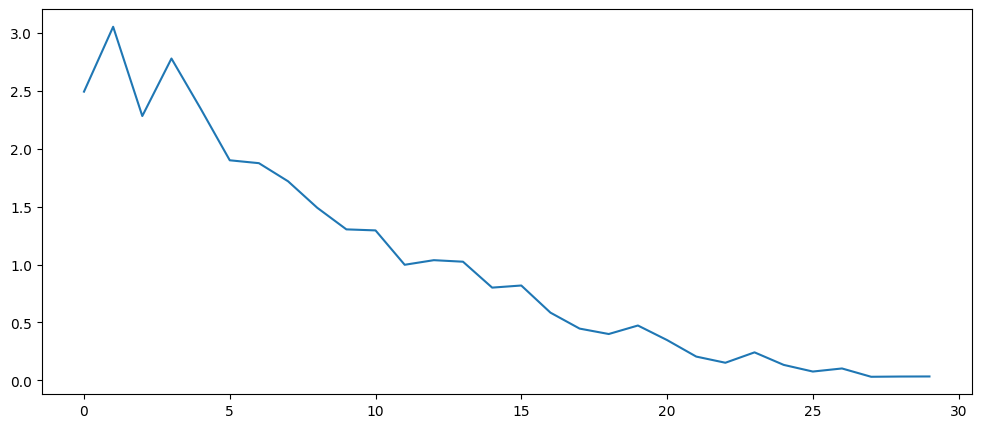

In [44]:
alpha = 0.7  # ✅ Set this to the value you used in run_apl

plt.figure(figsize=(12, 5))

# ✅ Plot CE and NCE Losses
for loss_type in ["ce", "nce"]:
    plt.plot(loss_histories[loss_type], label=f"{loss_type.upper()} Loss")

# ✅ Plot APL Active/Passive Losses
# ✅ Plot Combined APL Loss
if "apl" in loss_histories:
    combined_apl_loss = [
        alpha * active + (1 - alpha) * passive
        for active, passive in zip(
            loss_histories["apl"]["active_loss"], loss_histories["apl"]["passive_loss"]
        )
    ]
    plt.plot(combined_apl_loss, label="APL Combined Loss")


plt.title("Training Losses for CE, NCE, and APL")
plt.xlabel("Iteration")
plt.ylabel("Loss")
plt.legend()
plt.show()

# ✅ Plot Training and Validation Accuracy
plt.figure(figsize=(12, 5))
for loss_type in acc_histories:
    plt.plot(acc_histories[loss_type]["train"], label=f"{loss_type.upper()} Train Acc")
    plt.plot(acc_histories[loss_type]["val"], label=f"{loss_type.upper()} Val Acc")

plt.title("Training and Validation Accuracy for CE, NCE, and APL")
plt.xlabel("Epoch")
plt.ylabel("Accuracy (%)")
plt.legend()
plt.show()

In [137]:
import os

# List of loss types you want to delete checkpoints for
loss_types_to_delete =  ["ce"]#["ce", "nce","apl"]

# Directory containing the checkpoints
checkpoint_dir = "checkpoints"

# Delete the checkpoint files for the specified loss types
for loss_type in loss_types_to_delete:
    checkpoint_path = os.path.join(checkpoint_dir, f"model_checkpoint_{loss_type}.pkl")
    if os.path.exists(checkpoint_path):
        os.remove(checkpoint_path)
        print(f"Checkpoint for {loss_type.upper()} deleted successfully! ❌")
    else:
        print(f"No checkpoint found for {loss_type.upper()} to delete.")


Checkpoint for CE deleted successfully! ❌


In [138]:
import pickle
import os
import numpy as np
import matplotlib.pyplot as plt
from solver import Solver
from cnn import ThreeLayerConvNet
from helper_functions.apl import run_apl  # ✅ Corrected Import for APL

# ========================
# ✅ Define Paths and Params
# ========================
checkpoint_dir = "checkpoints"
os.makedirs(checkpoint_dir, exist_ok=True)

loss_types = [ "nce","ce", "apl"]
weight_scale = 0.001
hidden_dim = 500
reg = 0.001
alpha = 0.5 # 0.5

# Initialize Variables to store training stats
trained_models = {}
loss_histories = {}
acc_histories = {}

# ========================
# ✅ Training Loop for All Loss Types
# ========================
for loss_type in loss_types:
    checkpoint_path = os.path.join(checkpoint_dir, f"model_checkpoint_{loss_type}.pkl")

    # ========================
    # 🔄 Check if Checkpoint Exists
    # ========================
    if os.path.exists(checkpoint_path):
        print(f"Loading model for {loss_type.upper()} from checkpoint...")
        with open(checkpoint_path, "rb") as f:
            checkpoint = pickle.load(f)

        if loss_type == "apl":
            # ✅ Restore PyTorch APL model and solver stats
            apl_model = checkpoint["model"]
            train_acc_history = checkpoint["train_acc_history"]
            val_acc_history = checkpoint["val_acc_history"]
            combined_apl_loss_history = checkpoint["apl_loss_history"]
            print(f"{loss_type.upper()} checkpoint loaded successfully! ✅")

        else:
            # ✅ Restore CE/NCE models using ThreeLayerConvNet
            model = ThreeLayerConvNet(weight_scale=weight_scale, hidden_dim=hidden_dim, reg=reg)
            model.params = checkpoint["model"]

            # Reinitialize solver with loaded model
            solver = Solver(
                model,
                data,
                num_epochs=0,  # Skip retraining if not needed
                batch_size=50,
                update_rule="adam",
                optim_config={"learning_rate": 1e-3},
                verbose=True,
                print_every=20,
            )
            print(f"{loss_type.upper()} checkpoint loaded successfully! ✅")

    else:
        print(f"No checkpoint found for {loss_type.upper()}. Training from scratch...")

        # ========================
        # ⚡️ Initialize and Train Model
        # ========================
        if loss_type == "apl":
            # ✅ Use PyTorch APL Implementation
            (
                apl_model,
                test_loader,
                active_loss_history,
                passive_loss_history,
                train_acc_history,
                val_acc_history,
            ) = run_apl(
                alpha=0.7,
                lr=5e-5,
                num_epochs=1,  # ⚠️ Set to the same num_epochs as CE/NCE
                batch_size=50,
                print_every=20,
            )

            # ✅ Combine APL Losses (Active + Passive)
            combined_apl_loss_history = [
                alpha * active + (1 - alpha) * passive
                for active, passive in zip(active_loss_history, passive_loss_history)
            ]

            # ========================
            # 💾 Save Checkpoint After Training
            # ========================
            with open(checkpoint_path, "wb") as f:
                pickle.dump(
                    {
                        "model": apl_model.state_dict(),
                        "apl_loss_history": combined_apl_loss_history,
                        "train_acc_history": train_acc_history,
                        "val_acc_history": val_acc_history,
                    },
                    f,
                )
            print(f"Checkpoint for {loss_type.upper()} saved after training! 🎉")

        else:
            # ✅ CE and NCE (No Change)
            model = ThreeLayerConvNet(weight_scale=weight_scale, hidden_dim=hidden_dim, reg=reg)
            solver = Solver(
                model,
                data,
                num_epochs=1,  # ⚠️ Keep the same number of epochs as APL
                batch_size=50,
                update_rule="adam",
                optim_config={"learning_rate": 3e-5},#1e-4
                verbose=True,
                print_every=20,
            )

            # 🔥 Train Model with Specific Loss Type
            solver._train_with_loss_type(loss_type)

            # 💾 Save Checkpoint After Training
            with open(checkpoint_path, "wb") as f:
                pickle.dump({"model": model.params, "solver": solver}, f)
            print(f"Checkpoint for {loss_type.upper()} saved after training! 🎉")

    # ========================
    # ✅ Store Training Results
    # ========================
    if loss_type == "apl":
        # ✅ Store PyTorch APL Results
        trained_models["apl"] = apl_model
        loss_histories["apl"] = combined_apl_loss_history
        acc_histories["apl"] = {"train": train_acc_history, "val": val_acc_history}
    else:
        # ✅ Store CE/NCE Results as Before
        trained_models[loss_type] = {k: v.copy() for k, v in solver.model.params.items()}
        loss_histories[loss_type] = (
            solver.ce_loss_history
            if loss_type == "ce"
            else solver.nce_loss_history
        )
        acc_histories[loss_type] = {
            "train": solver.ce_train_acc_history
            if loss_type == "ce"
            else solver.nce_train_acc_history,
            "val": solver.ce_val_acc_history
            if loss_type == "ce"
            else solver.nce_val_acc_history,
        }


Loading model for NCE from checkpoint...
NCE checkpoint loaded successfully! ✅
No checkpoint found for CE. Training from scratch...
(Iteration 1 / 980) CE loss: 2.3048
(Epoch 0 / 1) CE train acc: 11.60; CE val acc: 11.80
(Iteration 21 / 980) CE loss: 2.3013
(Iteration 41 / 980) CE loss: 2.2743
(Iteration 61 / 980) CE loss: 2.3048
(Iteration 81 / 980) CE loss: 2.2763
(Iteration 101 / 980) CE loss: 2.3187
(Iteration 121 / 980) CE loss: 2.3121
(Iteration 141 / 980) CE loss: 2.2715
(Iteration 161 / 980) CE loss: 2.2330
(Iteration 181 / 980) CE loss: 2.2396
(Iteration 201 / 980) CE loss: 2.2469
(Iteration 221 / 980) CE loss: 2.3547
(Iteration 241 / 980) CE loss: 2.3658
(Iteration 261 / 980) CE loss: 2.2665
(Iteration 281 / 980) CE loss: 2.3720
(Iteration 301 / 980) CE loss: 2.2340
(Iteration 321 / 980) CE loss: 2.3284
(Iteration 341 / 980) CE loss: 2.2870
(Iteration 361 / 980) CE loss: 2.3288
(Iteration 381 / 980) CE loss: 2.1926
(Iteration 401 / 980) CE loss: 2.3015
(Iteration 421 / 980) C

In [139]:
import pickle

# Save model and solver after training
with open("model_checkpoint.pkl", "wb") as f:
    pickle.dump({"model": model.params, "solver": solver}, f)


In [144]:
from apl import APLCNN


In [145]:
model = APLCNN().to(device)
print(type(model))  # ✅ Should show <class 'APLCNN'>


<class 'apl.APLCNN'>


In [147]:
import torch
import numpy as np
from cnn import ThreeLayerConvNet

# ========================
# ✅ Define device
# ========================
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# ========================
# ✅ Initialize trained models & test loaders only ONCE
# ========================
if "trained_models" not in globals():
    trained_models = {}
    test_loaders = {}

# ✅ Check available models before checking accuracies
print(f"Available models before checking accuracy: {list(trained_models.keys())}")

# ========================
# ✅ Define reset_model() correctly
# ========================
def reset_model():
    """Reinitialize and return a new ThreeLayerConvNet."""
    return ThreeLayerConvNet(weight_scale=1e-2)  # ✅ Use same weight_scale as training

# ========================
# ✅ Loop to check accuracies
# ========================
for loss_type in trained_models.keys():  # ✅ Iterate only over available models
    if loss_type == "apl":
        print(f"Checking accuracy for APL model...")

        # ✅ Import APLCNN correctly
        from apl import APLCNN

        # ✅ Reinitialize APLCNN and load the saved state_dict
        apl_model = APLCNN(input_dim=(3, 32, 32), num_classes=10).to(device)
        apl_model.load_state_dict(trained_models["apl"])  # ✅ Load model correctly
        apl_model.eval()

        # ✅ APL Accuracy on Training Data
        X_train_tensor = torch.tensor(
            small_data["X_train"], dtype=torch.float32
        ).to(device)
        y_train_tensor = torch.tensor(small_data["y_train"], dtype=torch.long).to(device)

        with torch.no_grad():
            outputs_train = apl_model(X_train_tensor)
            _, predicted_train = torch.max(outputs_train, 1)
            train_correct = (predicted_train == y_train_tensor).sum().item()
            train_acc = 100 * train_correct / y_train_tensor.size(0)

        print(f"APL Train Accuracy: {train_acc:.2f}%")

        # ✅ APL Accuracy on Validation Data
        X_val_tensor = torch.tensor(
            small_data["X_val"], dtype=torch.float32
        ).to(device)
        y_val_tensor = torch.tensor(small_data["y_val"], dtype=torch.long).to(device)

        with torch.no_grad():
            outputs_val = apl_model(X_val_tensor)
            _, predicted_val = torch.max(outputs_val, 1)
            val_correct = (predicted_val == y_val_tensor).sum().item()
            val_acc = 100 * val_correct / y_val_tensor.size(0)

        print(f"APL Validation Accuracy: {val_acc:.2f}%\n")

    else:
        print(f"Checking accuracy for {loss_type.upper()} model...")

        # ✅ Correctly reset and load the model for CE/NCE
        model = reset_model()
        if loss_type in trained_models and "W1" in trained_models[loss_type]:
            model.params = {k: v.copy() for k, v in trained_models[loss_type].items()}  # ✅ Correctly load model params
        else:
            print(f"⚠️ Warning: No trained model found for {loss_type.upper()}. Skipping...")
            continue

        # ✅ CE/NCE Accuracy on Training Data
        X_train_np = small_data["X_train"]  # ✅ Already (N, C, H, W), no transpose needed
        scores_train = model.loss(X_train_np)
        predicted_train = np.argmax(scores_train, axis=1)
        train_correct = np.sum(predicted_train == small_data["y_train"])
        train_acc = 100 * train_correct / small_data["y_train"].shape[0]

        print(f"Training accuracy with {loss_type.upper()} loss: {train_acc:.2f}%")

        # ✅ CE/NCE Accuracy on Validation Data
        X_val_np = small_data["X_val"]  # ✅ Already (N, C, H, W), no transpose needed
        scores_val = model.loss(X_val_np)
        predicted_val = np.argmax(scores_val, axis=1)
        val_correct = np.sum(predicted_val == small_data["y_val"])
        val_acc = 100 * val_correct / small_data["y_val"].shape[0]

        print(f"Validation accuracy with {loss_type.upper()} loss: {val_acc:.2f}%\n")

# ✅ Final check after all accuracies
print(f"✅ Available models after checking: {list(trained_models.keys())}")


Available models before checking accuracy: ['nce', 'ce', 'apl']
Checking accuracy for NCE model...
Training accuracy with NCE loss: 18.00%
Validation accuracy with NCE loss: 43.30%

Checking accuracy for CE model...
Training accuracy with CE loss: 22.00%
Validation accuracy with CE loss: 41.70%

Checking accuracy for APL model...
APL Train Accuracy: 23.00%
APL Validation Accuracy: 44.30%

✅ Available models after checking: ['nce', 'ce', 'apl']
